<a href="https://colab.research.google.com/github<URI_PLACEHOLDER>" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloads the odc-colab Python module and runs it to setup ODC.

In [1]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

--2021-04-14 19:41:59--  https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13927 (14K) [text/plain]
Saving to: ‘odc_colab.py’

odc_colab.py        100%[===================>]  13.60K  --.-KB/s    in 0s      

2021-04-14 19:41:59 (92.8 MB/s) - ‘odc_colab.py’ saved [13927/13927]

Module datacube was not found; installing it...
Module utils was not found; cloning https://github.com/ceos-seo/data_cube_utilities.git to CWD...
Module hdmedians was not found; installing it...
Package postgresql was not found; installing it...
Module odc-gee was not found; cloning https://github.com/ceos-seo/odc-gee.git to CWD...


Downloads an existing index and populates the new ODC environment with it.

In [2]:
from odc_colab import populate_db
populate_db()

No database file supplied. Downloading default index.


<a id="top"></a>
# Cloud-Filtered Median Mosaic

This notebook can be used to create a custom Landsat cloud-filtered median mosaic for any time period and location. The mosaic can be output as a GeoTIFF product for analysis in external GIS tools. The median mosaic is quite common and reflects the "median" value of cloud-free pixels for all spectral bands in the time series. 

Users should review the "Cloud Statistics" notebook for more information about the temporal and spatial sample. An understanding of the underlying data is important for creating a valid mosaic for further analyses. In many cases, cloud contamination will create poor mosaics. With a careful review of the cloud coverage over a given region and time period, it is possible to improve the mosaics and avoid false outputs. 

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [3]:
%matplotlib inline

# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

# Load Data Cube Configuration
from odc_gee import earthengine
import utils.data_cube_utilities.data_access_api as dc_api  

import xarray as xr  
import numpy as np
import matplotlib.pyplot as plt

api = dc_api.DataAccessApi()
dc = earthengine.Datacube()

/usr/local/lib/python3.7/dist-packages/datacube/drivers/postgres/_connections.py:84: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=4EQsJdzTn0fQJOhNM-Cu5FQGlLebkfuRnGXm_hB1cEk&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g5gmWAxDqT4RHDsGYsSx2J07BG4M8RL7KB3SvkI7hYow8WZvHsUF5M

Successfully saved authorization token.


/usr/local/lib/python3.7/dist-packages/datacube/drivers/postgres/_connections.py:84: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


In [4]:
# Select a Product and Platform
product = "ls8_google"
platform = "LANDSAT_8"

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

In [5]:
# Select an analysis region (Latitude-Longitude) 
# Select a time period within the extents of the dataset (Year-Month-Day)

# Mombasa, Kenya
latitude = (-4.15, -3.90) 
longitude = (39.50, 39.75) 

# Define Time Range
# Landsat-8 time range: 07-Apr-2013 to current
time_extents = ('2020-01-01', '2020-12-30')

In [6]:
# The code below renders a map that can be used to view the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude,longitude)

## <span id="load_data">Load and Clean Data from the Data Cube [&#9652;](#top)</span>

In [7]:
landsat_dataset = dc.load(latitude=latitude,
                          longitude=longitude,
                          platform=platform,
                          time=time_extents,
                          product=product,
                          measurements=['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [8]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)
cleaned_dataset = landsat_dataset.where(cloud_mask)

## <span id="mosaics">Create Median Mosaic and View the Results [&#9652;](#top)</span>

In [9]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic
from utils.data_cube_utilities.dc_rgb import rgb

In [10]:
median_composite = create_median_mosaic(cleaned_dataset, cloud_mask)

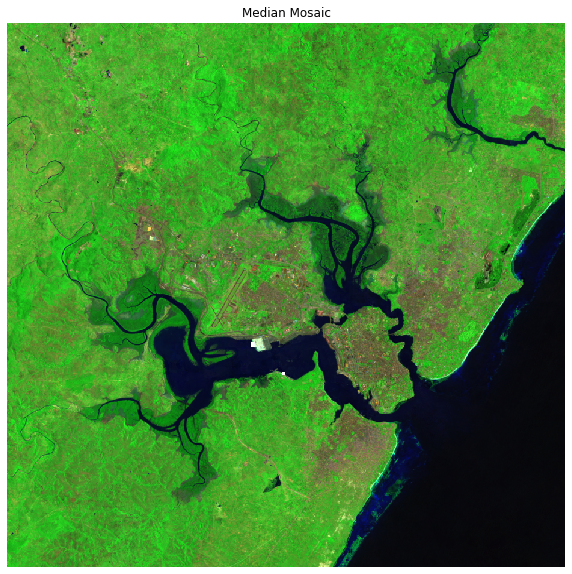

In [11]:
# Show Median Mosaic

# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

median_rgb = median_composite[['swir2', 'nir', 'green']].to_array()
median_rgb.plot.imshow(vmin=0, vmax=5000, figsize=(10,10))
plt.title("Median Mosaic")
plt.axis('off')
plt.show()

## <span id="export">Create GeoTIFF Output Product [&#9652;](#top)</span>

In [12]:
from utils.data_cube_utilities.import_export import export_slice_to_geotiff

In [16]:
# Change the name of the output file, or it will be overwritten for each run 

export_slice_to_geotiff(median_composite, './output/DEMO_median_composite.tif')